In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.FGVCAircraft(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 100/100 [00:02<00:00, 48.10it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/airplane_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
}

In [14]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name)
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 1 prompts for (40)Beechcraft 1900
['-A twin-engine turboprop airplane that seats up to 19 passengers\n-Has a cruising speed ofine 300 mph (483 km/h)\n-A typical range is 1,350 miles (2,174 km)\n.']

Filtered 2 prompts for (89)Metroliner
['TheMetrolineris a 19-seat, twin-turboprop business class airliner manufactured by Fairchild Aircraft.', 'TheMetroliner is a turboprop-powered regional airliner that was introducted in 1967.']

Filtered 1 prompts for (86)MD-80
['.']

Filtered 1 prompts for (7)737-700
['Aircraft description from AirFleets.']

Filtered 1 prompts for (79)Global Express
['.']

Filtered 1 prompts for (43)C-47
['The aircraft has a low-mounted cantilever wing and a tricycle landing gear.']

Filtered 1 prompts for (63)Dornier 328
['The DO328 aircraft is a high-wing, twin-engine, turboprop-powered plane.']

Filtered 1 prompts for (21)A300B4
['It is a twin-engine, wide-body aircraft that can carry up to 250 passengers.']

Filtered 1 prompts for (35)ATR-72
['.']

Filtere

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 178.56it/s]


In [16]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [17]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [18]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [19]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [20]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [21]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 21.00%
Accuracy of CLIP with text template (centroid): 23.88%
Accuracy of CLIP with text template (individual avg): 23.88%
Accuracy of CLIP with original GPT-3 text (centroid): 27.84%
Accuracy of CLIP with original GPT-3 text (individual avg): 27.78%
Accuracy of CLIP with filtered GPT-3 text (centroid): 28.77%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 29.22%
Accuracy of CLIP with combined original GPT-3 text (centroid): 25.83%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 25.14%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 25.89%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 25.14%


In [22]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [23]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=22.12%, std=0.015062161704893414
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=24.92%, std=0.01125631443483546


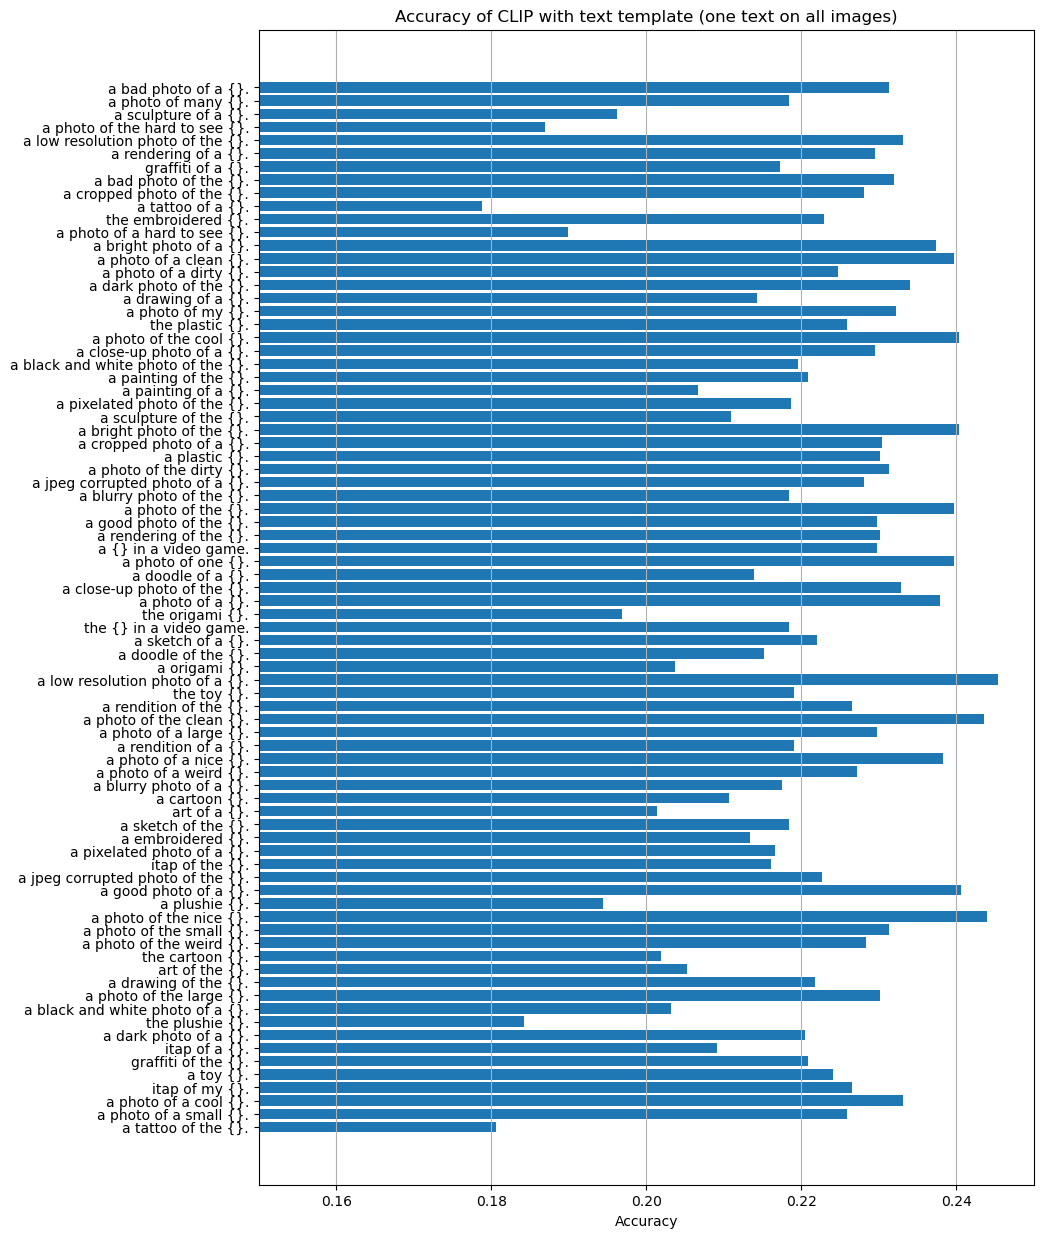

In [24]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [25]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [26]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [27]:
def print_top_pairs(similarity, text, top=10):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [28]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [29]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [30]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [31]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20)
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20)
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.73974609375
Class name similarity std: 0.09033203125
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (6)737-600 - (7)737-700, similarity: 0.99560546875
Rank 3: (4)737-400 - (6)737-600, similarity: 0.9951171875
Rank 4: (5)737-500 - (6)737-600, similarity: 0.99462890625
Rank 5: (6)737-600 - (8)737-800, similarity: 0.99462890625
Rank 6: (7)737-700 - (8)737-800, similarity: 0.994140625
Rank 7: (5)737-500 - (9)737-900, similarity: 0.994140625
Rank 8: (4)737-400 - (5)737-500, similarity: 0.994140625
Rank 9: (27)A330-200 - (28)A330-300, similarity: 0.99365234375
Rank 10: (3)737-300 - (5)737-500, similarity: 0.99365234375


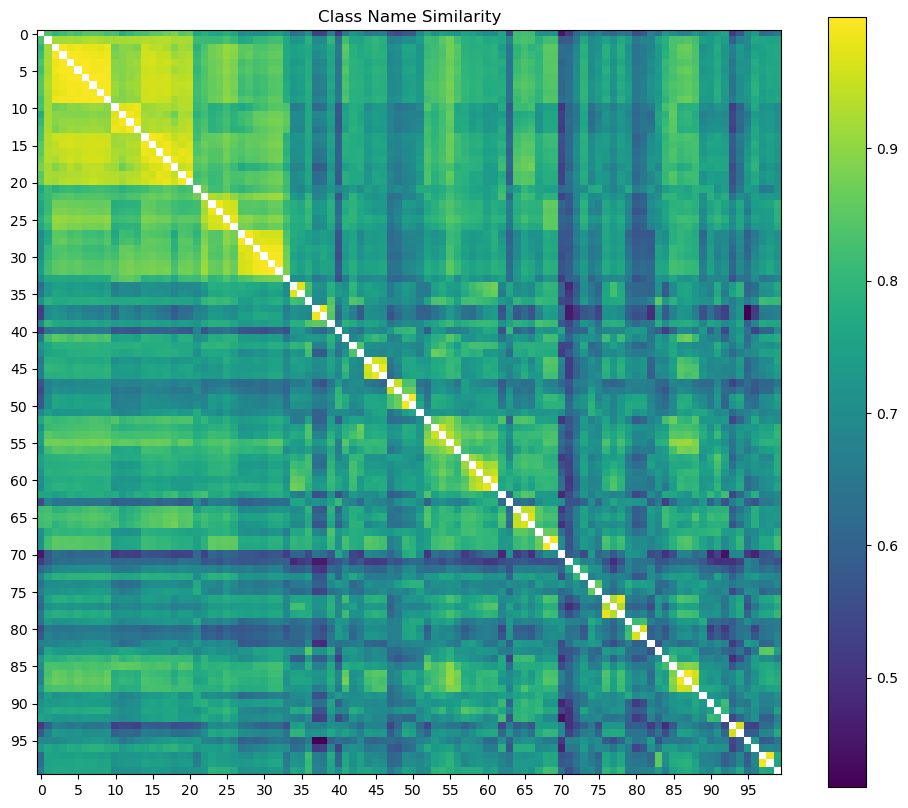

Text template similarity mean: 0.771484375
Text template similarity std: 0.07659912109375
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 3: (6)737-600 - (7)737-700, similarity: 0.99755859375
Rank 4: (19)777-200 - (20)777-300, similarity: 0.99755859375
Rank 5: (8)737-800 - (9)737-900, similarity: 0.99755859375
Rank 6: (7)737-700 - (9)737-900, similarity: 0.9970703125
Rank 7: (6)737-600 - (8)737-800, similarity: 0.9970703125
Rank 8: (16)767-200 - (17)767-300, similarity: 0.9970703125
Rank 9: (6)737-600 - (9)737-900, similarity: 0.9970703125
Rank 10: (27)A330-200 - (28)A330-300, similarity: 0.9970703125


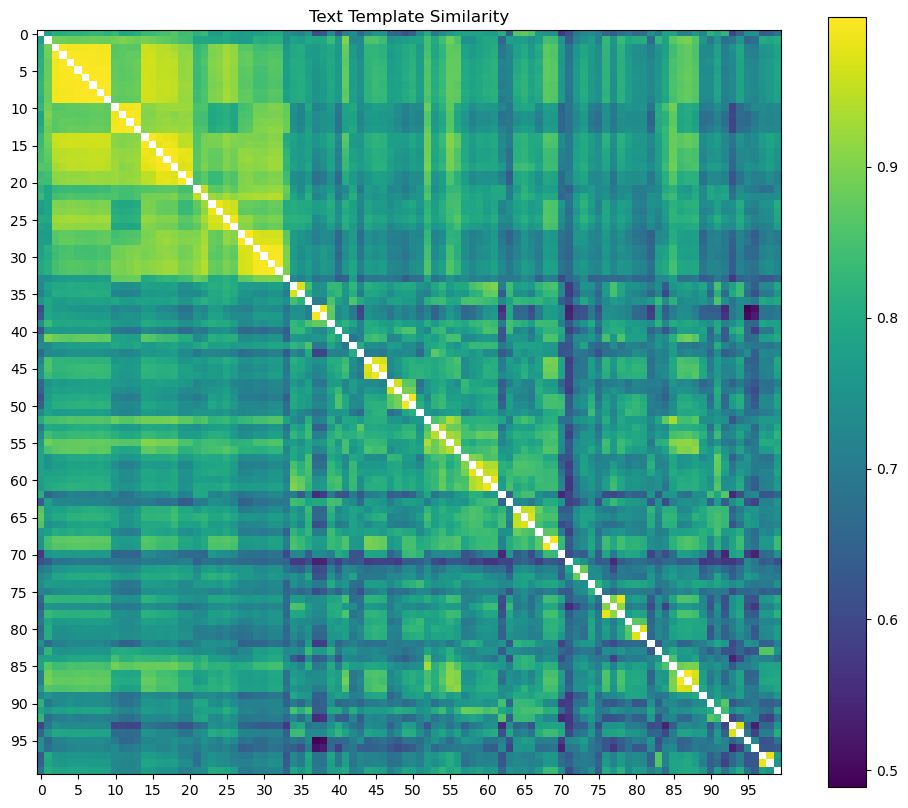

Original gpt-3 text similarity mean: 0.775390625
Original gpt-3 text similarity std: 0.0770263671875
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.99853515625
Rank 2: (6)737-600 - (9)737-900, similarity: 0.998046875
Rank 3: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, similarity: 0.998046875
Rank 5: (17)767-300 - (18)767-400, similarity: 0.998046875
Rank 6: (30)A340-300 - (32)A340-600, similarity: 0.99755859375
Rank 7: (30)A340-300 - (31)A340-500, similarity: 0.9970703125
Rank 8: (29)A340-200 - (30)A340-300, similarity: 0.9970703125
Rank 9: (5)737-500 - (9)737-900, similarity: 0.9970703125
Rank 10: (6)737-600 - (7)737-700, similarity: 0.99658203125


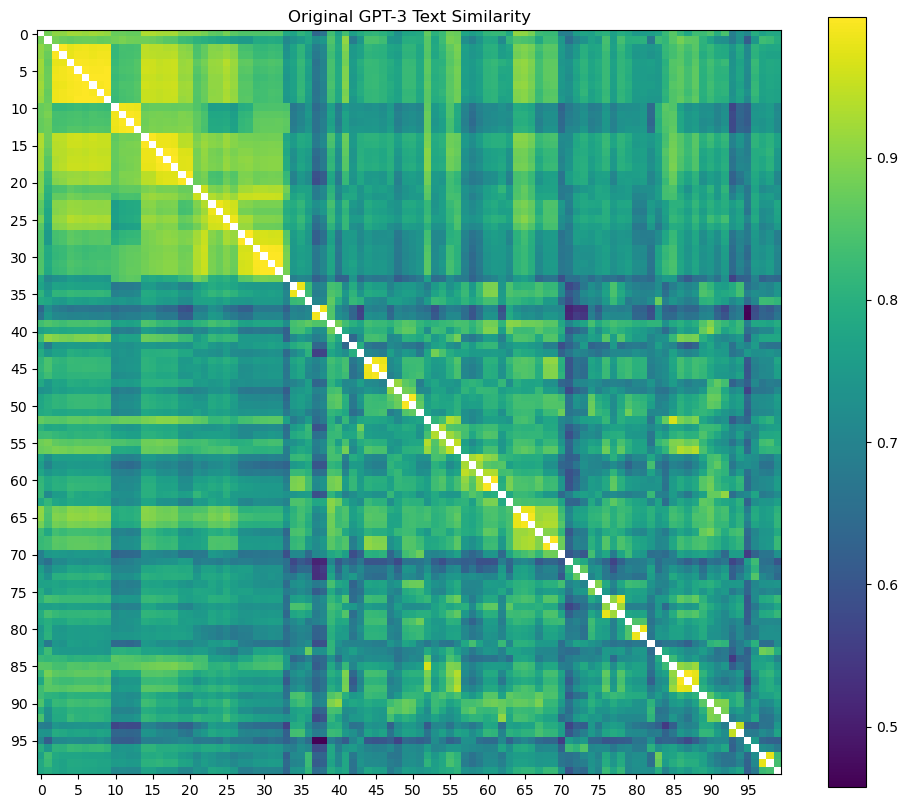

Filtered gpt-3 text similarity mean: 0.7705078125
Filtered gpt-3 text similarity std: 0.0784912109375
Rank 1: (5)737-500 - (6)737-600, similarity: 0.99853515625
Rank 2: (31)A340-500 - (32)A340-600, similarity: 0.99853515625
Rank 3: (6)737-600 - (9)737-900, similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, similarity: 0.998046875
Rank 5: (5)737-500 - (9)737-900, similarity: 0.99755859375
Rank 6: (17)767-300 - (18)767-400, similarity: 0.99755859375
Rank 7: (30)A340-300 - (32)A340-600, similarity: 0.99755859375
Rank 8: (4)737-400 - (5)737-500, similarity: 0.99755859375
Rank 9: (6)737-600 - (8)737-800, similarity: 0.99755859375
Rank 10: (7)737-700 - (9)737-900, similarity: 0.99755859375


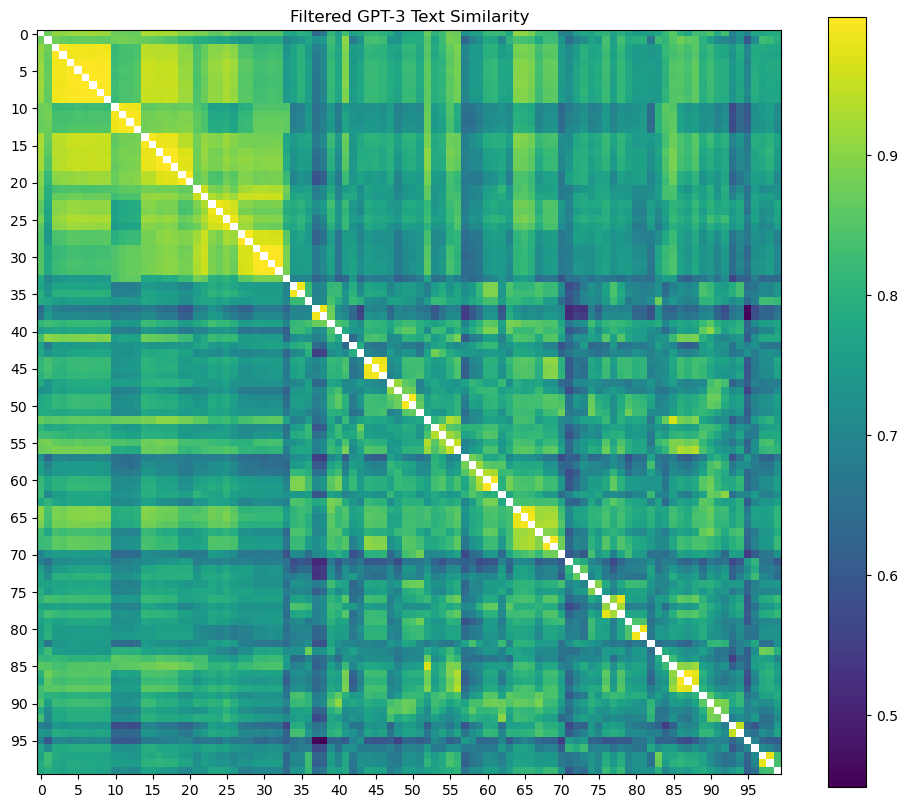

In [32]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.8623046875
Image similarity std: 0.07965087890625
Rank 1: (80)Gulfstream IV - (81)Gulfstream V, similarity: 0.99755859375
Rank 2: (49)Cessna 525 - (50)Cessna 560, similarity: 0.99365234375
Rank 3: (70)Embraer Legacy 600 - (79)Global Express, similarity: 0.99365234375
Rank 4: (3)737-300 - (5)737-500, similarity: 0.99267578125
Rank 5: (39)BAE-125 - (50)Cessna 560, similarity: 0.9921875
Rank 6: (3)737-300 - (4)737-400, similarity: 0.99169921875
Rank 7: (37)BAE 146-200 - (38)BAE 146-300, similarity: 0.99169921875
Rank 8: (51)Challenger 600 - (70)Embraer Legacy 600, similarity: 0.99169921875
Rank 9: (3)737-300 - (8)737-800, similarity: 0.9912109375
Rank 10: (34)ATR-42 - (35)ATR-72, similarity: 0.9912109375


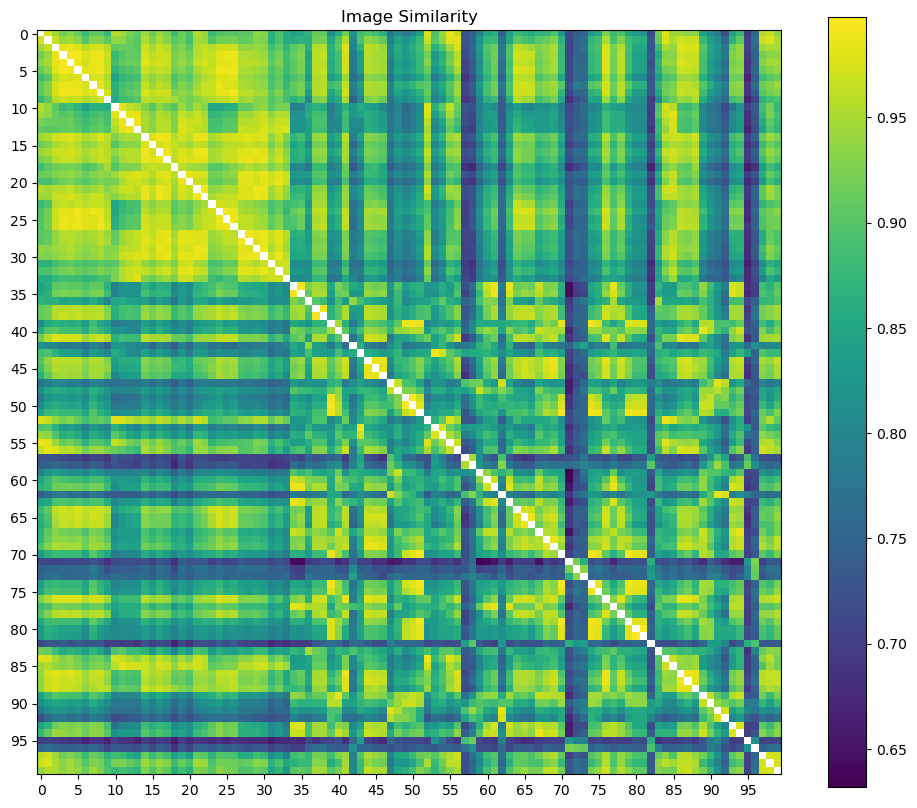

Image to class name similarity mean: 0.2379150390625
Image to class name similarity std: 0.035247802734375
Image to class name similarity diagonal mean: 0.295166015625
Image to class name similarity diagonal std: 0.0189666748046875
Image to class name similarity non-diagonal mean: 0.2374267578125
Image to class name similarity non-diagonal std: 0.034912109375
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.2431640625
Rank 1: (83)Il-76 - (39)BAE-125, similarity: 0.326171875
Rank 2: (80)Gulfstream IV - (81)Gulfstream V, similarity: 0.32275390625
Rank 3: (81)Gulfstream V - (80)Gulfstream IV, similarity: 0.322021484375
Rank 4: (47)Cessna 172 - (48)Cessna 208, similarity: 0.32177734375
Rank 5: (79)Global Express - (70)Embraer Legacy 600, similarity: 0.32080078125
Rank 6: (75)Falcon 900 - (74)Falcon 2000, similarity: 0.3203125
Rank 7: (83)Il-76 - (37)BAE 146-200, similarity: 0.317138671875
Rank 8: (39)BAE-125 - (74)Falcon 2000, similarity: 0.316650390625
Rank 9: (8

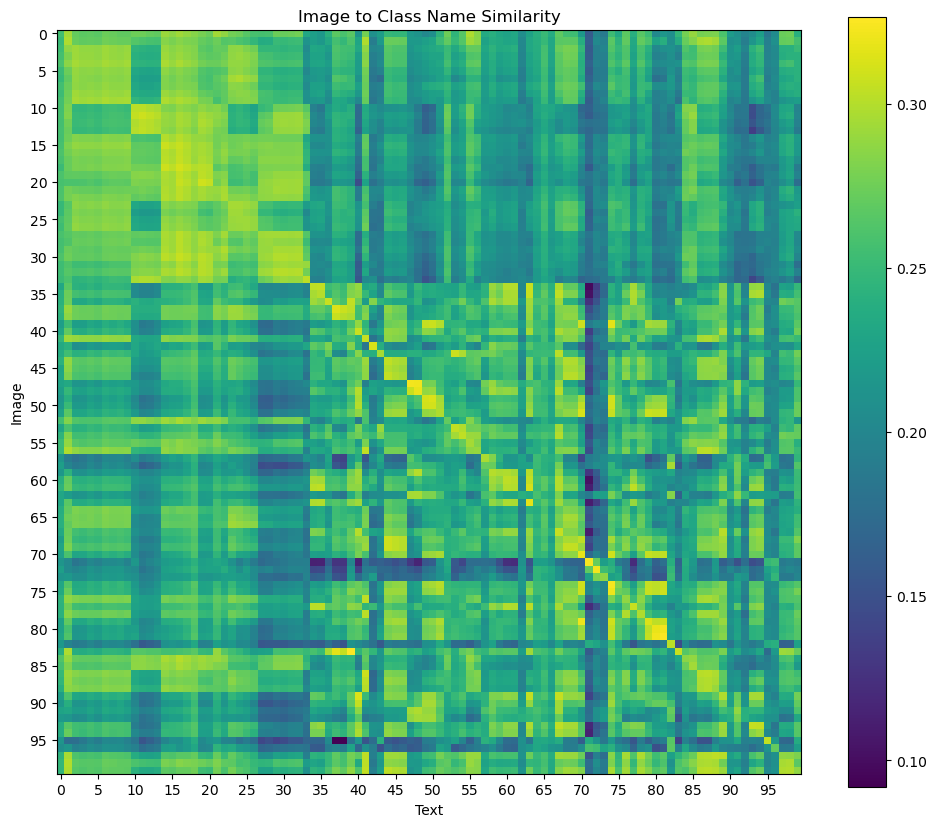

Rank 1: (17)767-300 - (16)767-200, error rate: 0.7352941176470589
Rank 2: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.7352941176470589
Rank 3: (18)767-400 - (16)767-200, error rate: 0.696969696969697
Rank 4: (58)DHC-1 - (82)Hawk T1, error rate: 0.6666666666666666
Rank 5: (86)MD-80 - (41)Boeing 717, error rate: 0.6470588235294118
Rank 6: (75)Falcon 900 - (74)Falcon 2000, error rate: 0.6060606060606061
Rank 7: (28)A330-300 - (16)767-200, error rate: 0.5757575757575758
Rank 8: (83)Il-76 - (39)BAE-125, error rate: 0.5588235294117647
Rank 9: (39)BAE-125 - (74)Falcon 2000, error rate: 0.5454545454545454
Rank 10: (14)757-200 - (16)767-200, error rate: 0.5294117647058824
Rank 11: (92)SR-20 - (48)Cessna 208, error rate: 0.5294117647058824
Rank 12: (79)Global Express - (70)Embraer Legacy 600, error rate: 0.5151515151515151
Rank 13: (12)747-300 - (11)747-200, error rate: 0.5151515151515151
Rank 14: (19)777-200 - (16)767-200, error rate: 0.5151515151515151
Rank 15: (20)777-300 - (19)777-20

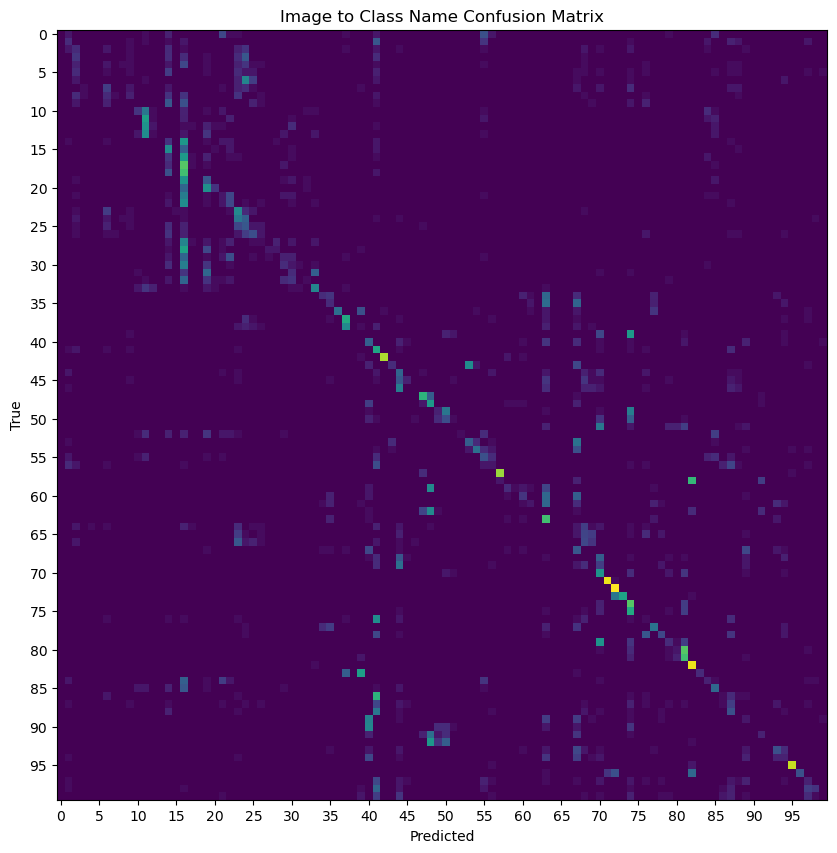

Image to text template (centroid) similarity mean: 0.2509765625
Image to text template (centroid) similarity std: 0.0386962890625
Image to text template (centroid) similarity diagonal mean: 0.315185546875
Image to text template (centroid) similarity diagonal std: 0.0178070068359375
Image to text template (centroid) similarity non-diagonal mean: 0.250244140625
Image to text template (centroid) similarity non-diagonal std: 0.038299560546875
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.259765625
Rank 1: (83)Il-76 - (39)BAE-125, similarity: 0.344482421875
Rank 2: (81)Gulfstream V - (80)Gulfstream IV, similarity: 0.341796875
Rank 3: (80)Gulfstream IV - (81)Gulfstream V, similarity: 0.33837890625
Rank 4: (83)Il-76 - (37)BAE 146-200, similarity: 0.33740234375
Rank 5: (47)Cessna 172 - (48)Cessna 208, similarity: 0.337158203125
Rank 6: (37)BAE 146-200 - (38)BAE 146-300, similarity: 0.336669921875
Rank 7: (79)Global Express - (70)Embraer Legacy 600, si

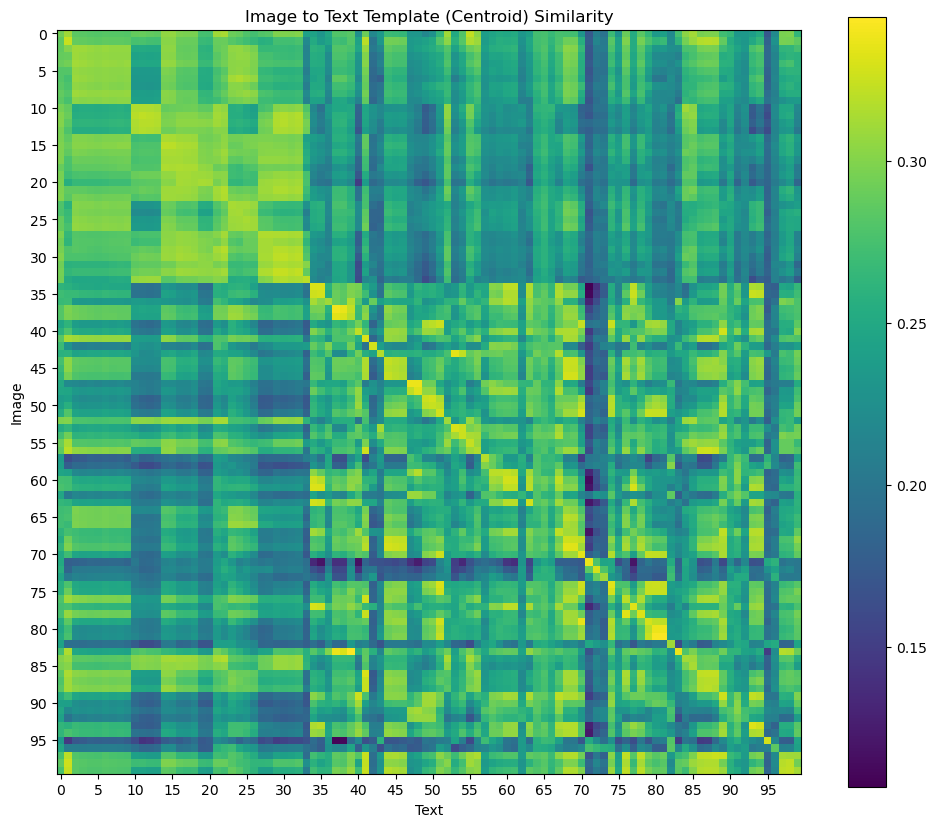

Rank 1: (43)C-47 - (53)DC-3, error rate: 0.696969696969697
Rank 2: (65)E-190 - (68)ERJ 135, error rate: 0.6176470588235294
Rank 3: (38)BAE 146-300 - (37)BAE 146-200, error rate: 0.5882352941176471
Rank 4: (49)Cessna 525 - (50)Cessna 560, error rate: 0.5757575757575758
Rank 5: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.5588235294117647
Rank 6: (79)Global Express - (70)Embraer Legacy 600, error rate: 0.5454545454545454
Rank 7: (62)DR-400 - (47)Cessna 172, error rate: 0.5294117647058824
Rank 8: (58)DHC-1 - (82)Hawk T1, error rate: 0.48484848484848486
Rank 9: (78)Fokker 70 - (76)Fokker 100, error rate: 0.45454545454545453
Rank 10: (46)CRJ-900 - (68)ERJ 135, error rate: 0.45454545454545453
Rank 11: (92)SR-20 - (48)Cessna 208, error rate: 0.4411764705882353
Rank 12: (47)Cessna 172 - (48)Cessna 208, error rate: 0.4411764705882353
Rank 13: (6)737-600 - (24)A319, error rate: 0.42424242424242425
Rank 14: (64)E-170 - (68)ERJ 135, error rate: 0.42424242424242425
Rank 15: (51)Challenger 60

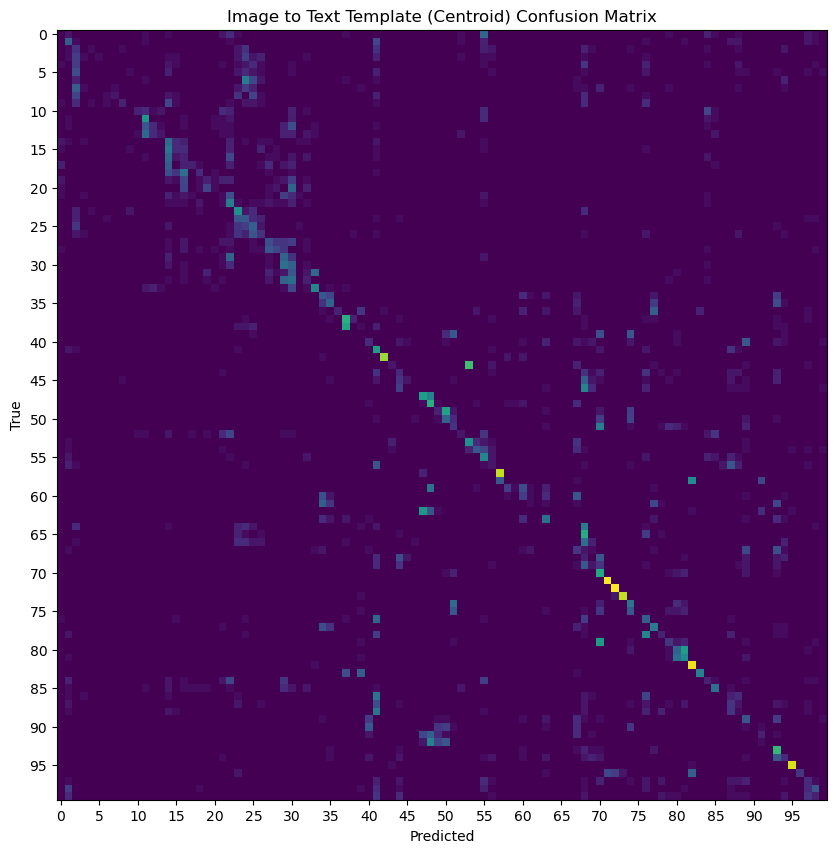

Image to text template (individual avg) similarity mean: 0.22727832198143005
Image to text template (individual avg) similarity std: 0.03500032797455788
Image to text template (individual avg) similarity diagonal mean: 0.2852539122104645
Image to text template (individual avg) similarity diagonal std: 0.01666097342967987
Image to text template (individual avg) similarity non-diagonal mean: 0.22669270634651184
Image to text template (individual avg) similarity non-diagonal std: 0.03464533016085625
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.2583285570144653
Rank 1: (83)Il-76 - (39)BAE-125, similarity: 0.3115234375
Rank 2: (81)Gulfstream V - (80)Gulfstream IV, similarity: 0.30712890625
Rank 3: (80)Gulfstream IV - (81)Gulfstream V, similarity: 0.30712890625
Rank 4: (79)Global Express - (70)Embraer Legacy 600, similarity: 0.30712890625
Rank 5: (47)Cessna 172 - (48)Cessna 208, similarity: 0.306640625
Rank 6: (69)ERJ 145 - (68)ERJ 135, simil

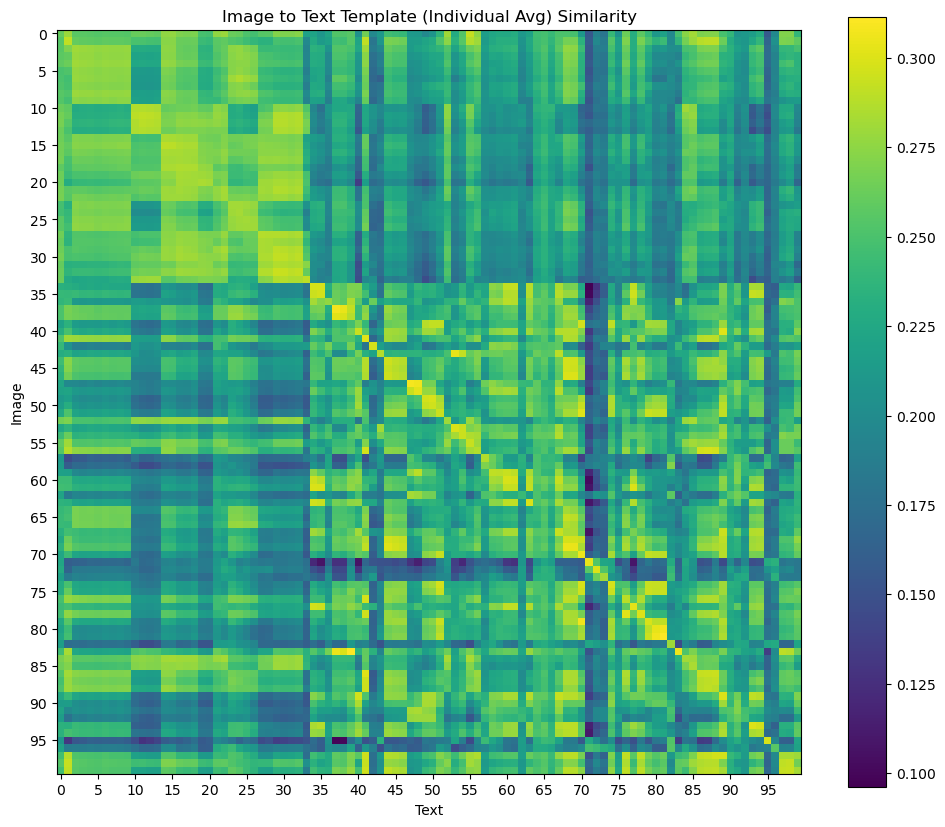

Rank 1: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.8235294117647058
Rank 2: (62)DR-400 - (47)Cessna 172, error rate: 0.6764705882352942
Rank 3: (43)C-47 - (53)DC-3, error rate: 0.6666666666666666
Rank 4: (65)E-190 - (68)ERJ 135, error rate: 0.6470588235294118
Rank 5: (79)Global Express - (70)Embraer Legacy 600, error rate: 0.6363636363636364
Rank 6: (49)Cessna 525 - (50)Cessna 560, error rate: 0.6060606060606061
Rank 7: (32)A340-600 - (29)A340-200, error rate: 0.5882352941176471
Rank 8: (38)BAE 146-300 - (37)BAE 146-200, error rate: 0.5882352941176471
Rank 9: (39)BAE-125 - (70)Embraer Legacy 600, error rate: 0.48484848484848486
Rank 10: (30)A340-300 - (29)A340-200, error rate: 0.48484848484848486
Rank 11: (15)757-300 - (14)757-200, error rate: 0.48484848484848486
Rank 12: (64)E-170 - (68)ERJ 135, error rate: 0.48484848484848486
Rank 13: (51)Challenger 600 - (70)Embraer Legacy 600, error rate: 0.42424242424242425
Rank 14: (0)707-320 - (55)DC-8, error rate: 0.42424242424242425
R

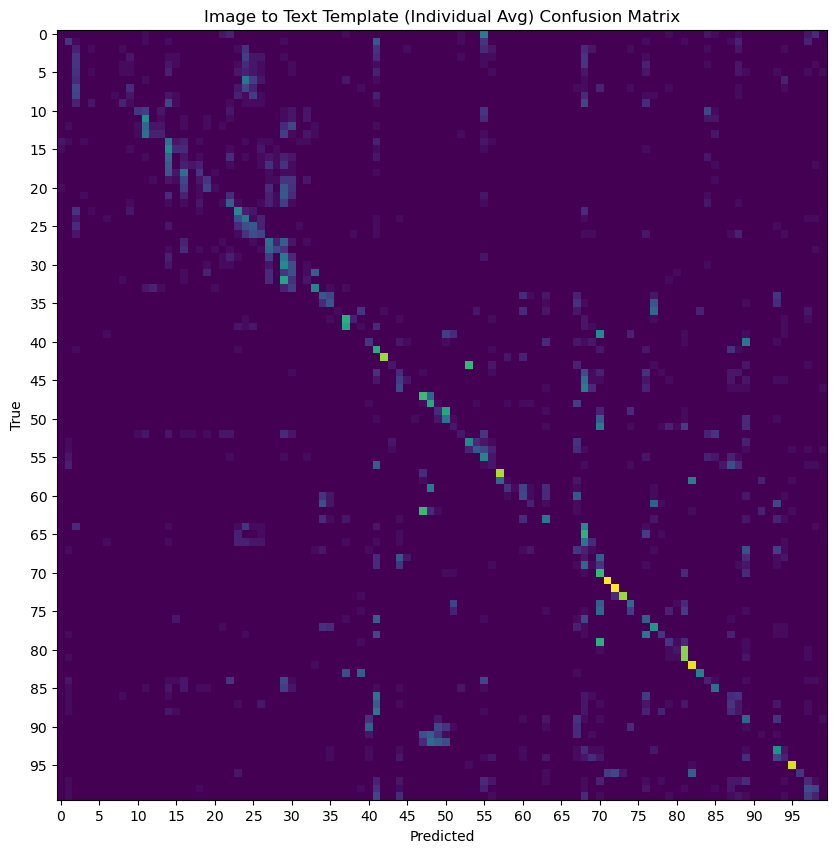

Image to original gpt-3 text (centroid) similarity mean: 0.2430419921875
Image to original gpt-3 text (centroid) similarity std: 0.0413818359375
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.314208984375
Image to original gpt-3 text (centroid) similarity diagonal std: 0.00914764404296875
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.242431640625
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.04095458984375
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.2958984375
Rank 1: (69)ERJ 145 - (68)ERJ 135, similarity: 0.331787109375
Rank 2: (68)ERJ 135 - (44)CRJ-200, similarity: 0.33154296875
Rank 3: (68)ERJ 135 - (45)CRJ-700, similarity: 0.32958984375
Rank 4: (68)ERJ 135 - (69)ERJ 145, similarity: 0.32958984375
Rank 5: (69)ERJ 145 - (44)CRJ-200, similarity: 0.329345703125
Rank 6: (69)ERJ 145 - (45)CRJ-700, similarity: 0.32763671875
Rank 7: (68)ERJ 135 - (46)CRJ-900, similarit

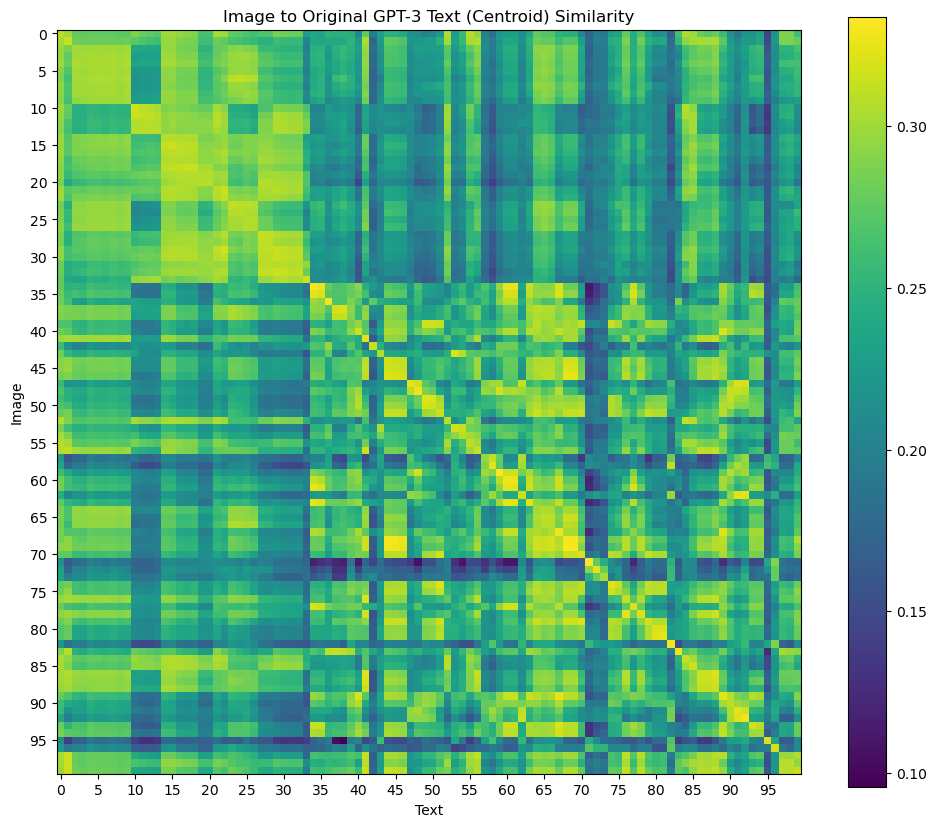

Rank 1: (57)DH-82 - (58)DHC-1, error rate: 0.6666666666666666
Rank 2: (62)DR-400 - (92)SR-20, error rate: 0.6470588235294118
Rank 3: (32)A340-600 - (29)A340-200, error rate: 0.5588235294117647
Rank 4: (43)C-47 - (53)DC-3, error rate: 0.5454545454545454
Rank 5: (50)Cessna 560 - (49)Cessna 525, error rate: 0.5294117647058824
Rank 6: (40)Beechcraft 1900 - (89)Metroliner, error rate: 0.48484848484848486
Rank 7: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.4411764705882353
Rank 8: (28)A330-300 - (27)A330-200, error rate: 0.42424242424242425
Rank 9: (63)Dornier 328 - (60)DHC-8-100, error rate: 0.42424242424242425
Rank 10: (86)MD-80 - (41)Boeing 717, error rate: 0.4117647058823529
Rank 11: (76)Fokker 100 - (41)Boeing 717, error rate: 0.3939393939393939
Rank 12: (88)MD-90 - (41)Boeing 717, error rate: 0.3939393939393939
Rank 13: (77)Fokker 50 - (34)ATR-42, error rate: 0.38235294117647056
Rank 14: (66)E-195 - (68)ERJ 135, error rate: 0.36363636363636365
Rank 15: (39)BAE-125 - (49)Cessna 

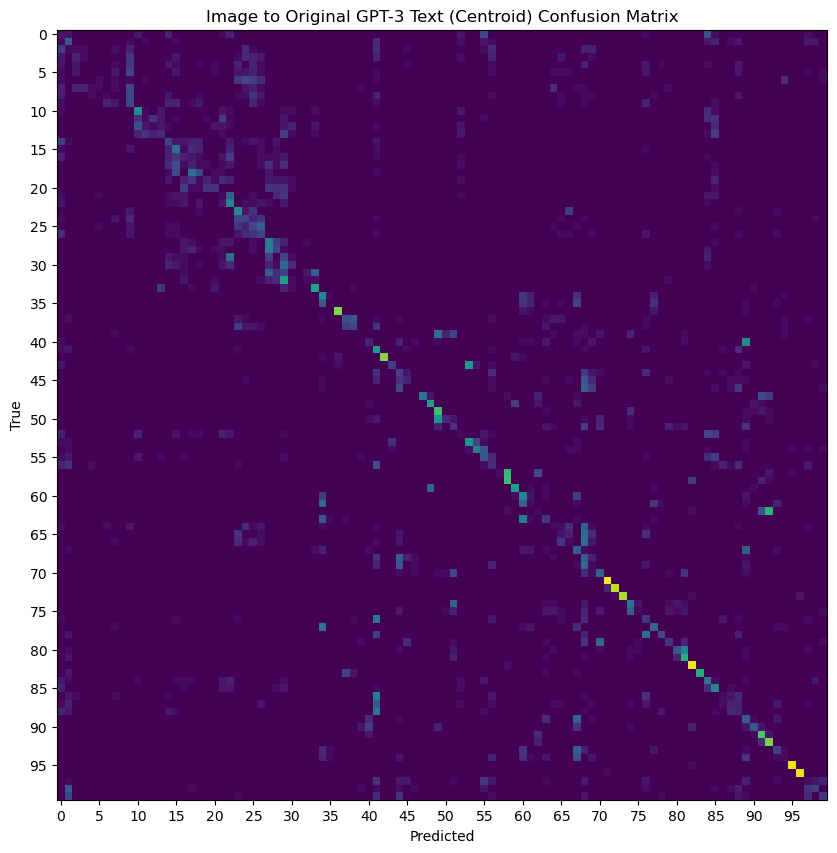

Image to original gpt-3 text (individual avg) similarity mean: 0.2366713136434555
Image to original gpt-3 text (individual avg) similarity std: 0.040498677641153336
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.3060034215450287
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.010845774784684181
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.23597098886966705
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.04008087143301964
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.2967840433120728
Rank 1: (69)ERJ 145 - (68)ERJ 135, similarity: 0.3251953125
Rank 2: (68)ERJ 135 - (44)CRJ-200, similarity: 0.3232421875
Rank 3: (68)ERJ 135 - (69)ERJ 145, similarity: 0.3232421875
Rank 4: (68)ERJ 135 - (45)CRJ-700, similarity: 0.322509765625
Rank 5: (86)MD-80 - (41)Boeing 717, similarity: 0.3212890625
Rank 6: (69)ERJ 145 - (44)CRJ-200, simil

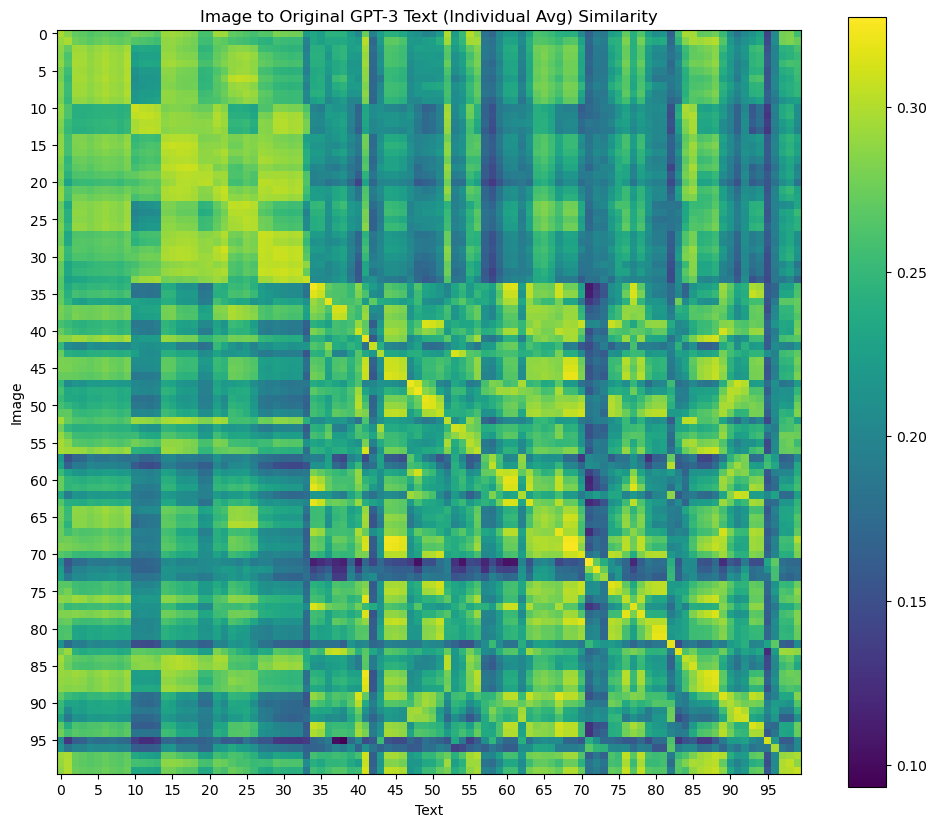

Rank 1: (50)Cessna 560 - (49)Cessna 525, error rate: 0.7352941176470589
Rank 2: (28)A330-300 - (27)A330-200, error rate: 0.6666666666666666
Rank 3: (43)C-47 - (53)DC-3, error rate: 0.6363636363636364
Rank 4: (62)DR-400 - (91)PA-28, error rate: 0.5882352941176471
Rank 5: (18)767-400 - (17)767-300, error rate: 0.5757575757575758
Rank 6: (39)BAE-125 - (49)Cessna 525, error rate: 0.5454545454545454
Rank 7: (59)DHC-6 - (48)Cessna 208, error rate: 0.5
Rank 8: (86)MD-80 - (41)Boeing 717, error rate: 0.5
Rank 9: (57)DH-82 - (58)DHC-1, error rate: 0.48484848484848486
Rank 10: (76)Fokker 100 - (41)Boeing 717, error rate: 0.48484848484848486
Rank 11: (66)E-195 - (68)ERJ 135, error rate: 0.48484848484848486
Rank 12: (79)Global Express - (70)Embraer Legacy 600, error rate: 0.45454545454545453
Rank 13: (65)E-190 - (68)ERJ 135, error rate: 0.4411764705882353
Rank 14: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.4411764705882353
Rank 15: (64)E-170 - (68)ERJ 135, error rate: 0.42424242424242425


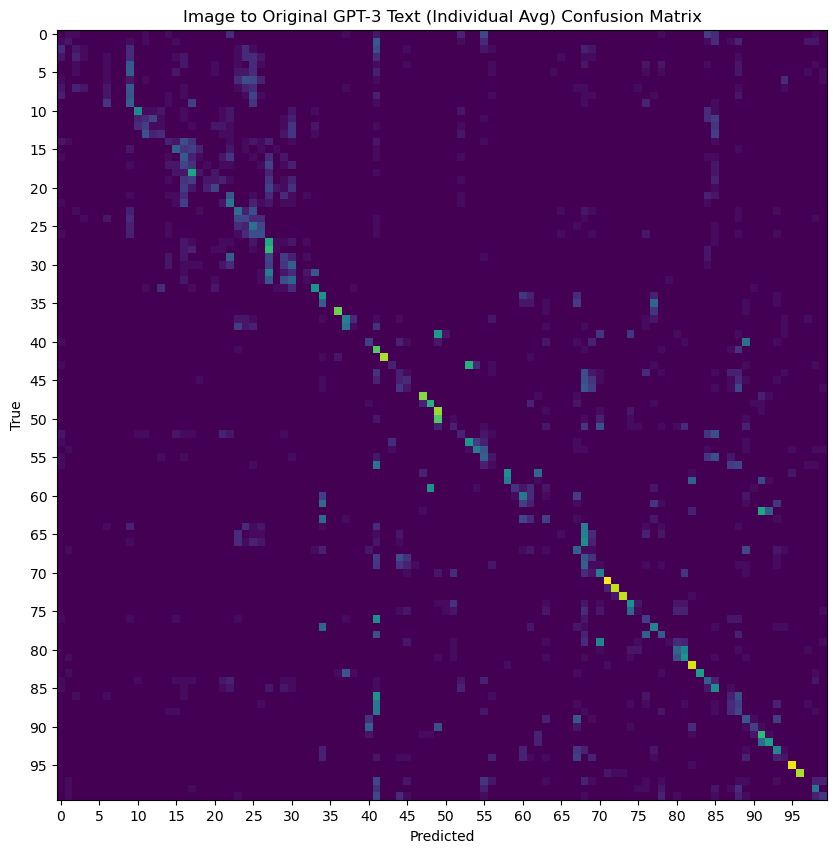

Image to filtered gpt-3 text (centroid) similarity mean: 0.2423095703125
Image to filtered gpt-3 text (centroid) similarity std: 0.0418701171875
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.314697265625
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.0091400146484375
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.2415771484375
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.04144287109375
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.302734375
Rank 1: (69)ERJ 145 - (68)ERJ 135, similarity: 0.331787109375
Rank 2: (68)ERJ 135 - (44)CRJ-200, similarity: 0.33154296875
Rank 3: (68)ERJ 135 - (45)CRJ-700, similarity: 0.32958984375
Rank 4: (68)ERJ 135 - (69)ERJ 145, similarity: 0.32958984375
Rank 5: (69)ERJ 145 - (44)CRJ-200, similarity: 0.329345703125
Rank 6: (69)ERJ 145 - (45)CRJ-700, similarity: 0.32763671875
Rank 7: (68)ERJ 135 - (46)CRJ-900, similarity

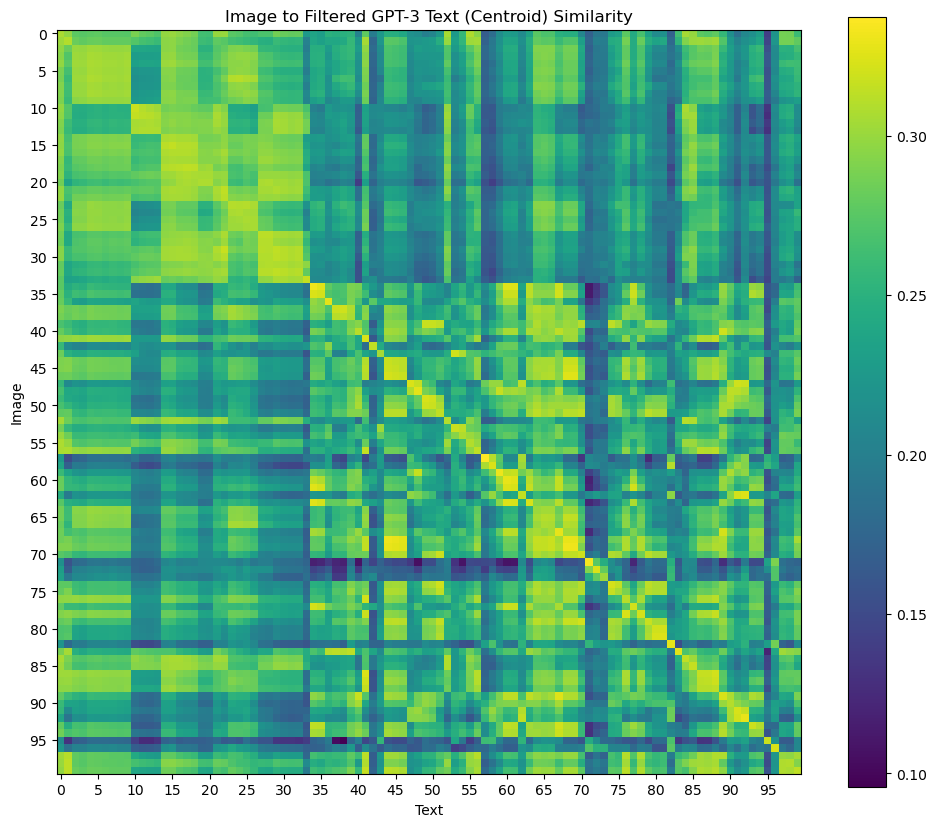

Rank 1: (62)DR-400 - (92)SR-20, error rate: 0.6764705882352942
Rank 2: (43)C-47 - (53)DC-3, error rate: 0.6363636363636364
Rank 3: (50)Cessna 560 - (49)Cessna 525, error rate: 0.5882352941176471
Rank 4: (32)A340-600 - (29)A340-200, error rate: 0.5588235294117647
Rank 5: (40)Beechcraft 1900 - (89)Metroliner, error rate: 0.48484848484848486
Rank 6: (28)A330-300 - (27)A330-200, error rate: 0.45454545454545453
Rank 7: (86)MD-80 - (41)Boeing 717, error rate: 0.4411764705882353
Rank 8: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.4411764705882353
Rank 9: (63)Dornier 328 - (60)DHC-8-100, error rate: 0.42424242424242425
Rank 10: (88)MD-90 - (41)Boeing 717, error rate: 0.3939393939393939
Rank 11: (66)E-195 - (68)ERJ 135, error rate: 0.3939393939393939
Rank 12: (76)Fokker 100 - (41)Boeing 717, error rate: 0.3939393939393939
Rank 13: (77)Fokker 50 - (34)ATR-42, error rate: 0.38235294117647056
Rank 14: (89)Metroliner - (67)EMB-120, error rate: 0.38235294117647056
Rank 15: (39)BAE-125 - (49)

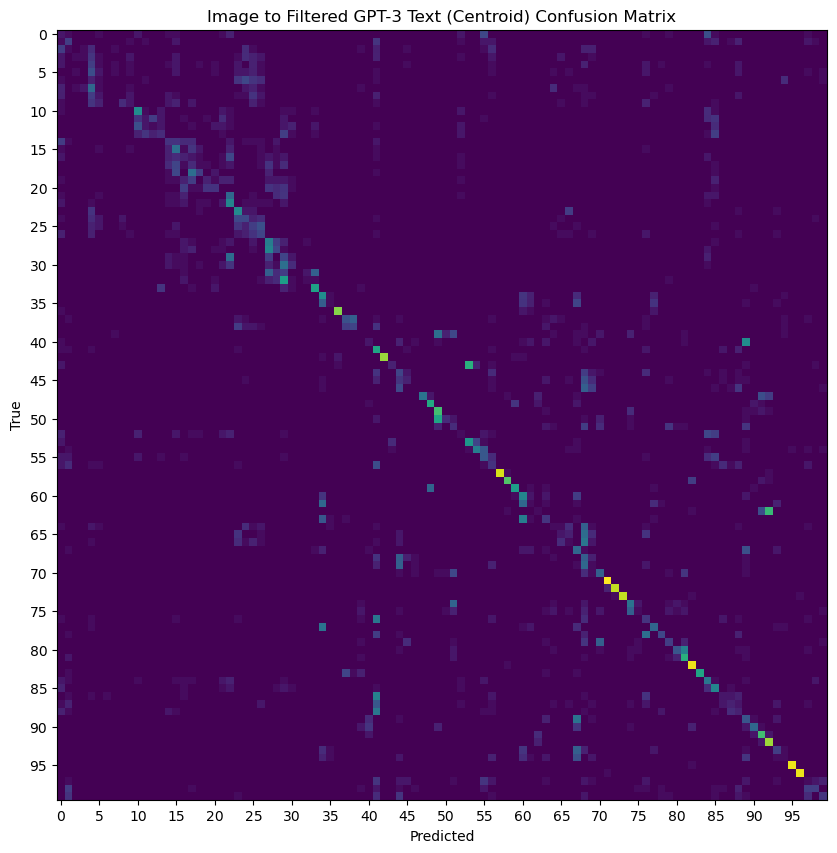

Image to filtered gpt-3 text (individual avg) similarity mean: 0.23692196607589722
Image to filtered gpt-3 text (individual avg) similarity std: 0.04107410088181496
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.30759522318840027
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.009119695983827114
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.23620809614658356
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.04064876213669777
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.3022212982177734
Rank 1: (69)ERJ 145 - (68)ERJ 135, similarity: 0.3251953125
Rank 2: (68)ERJ 135 - (69)ERJ 145, similarity: 0.3232421875
Rank 3: (68)ERJ 135 - (44)CRJ-200, similarity: 0.3232421875
Rank 4: (68)ERJ 135 - (45)CRJ-700, similarity: 0.322509765625
Rank 5: (69)ERJ 145 - (44)CRJ-200, similarity: 0.3212890625
Rank 6: (86)MD-80 - (41)Boeing 717, simi

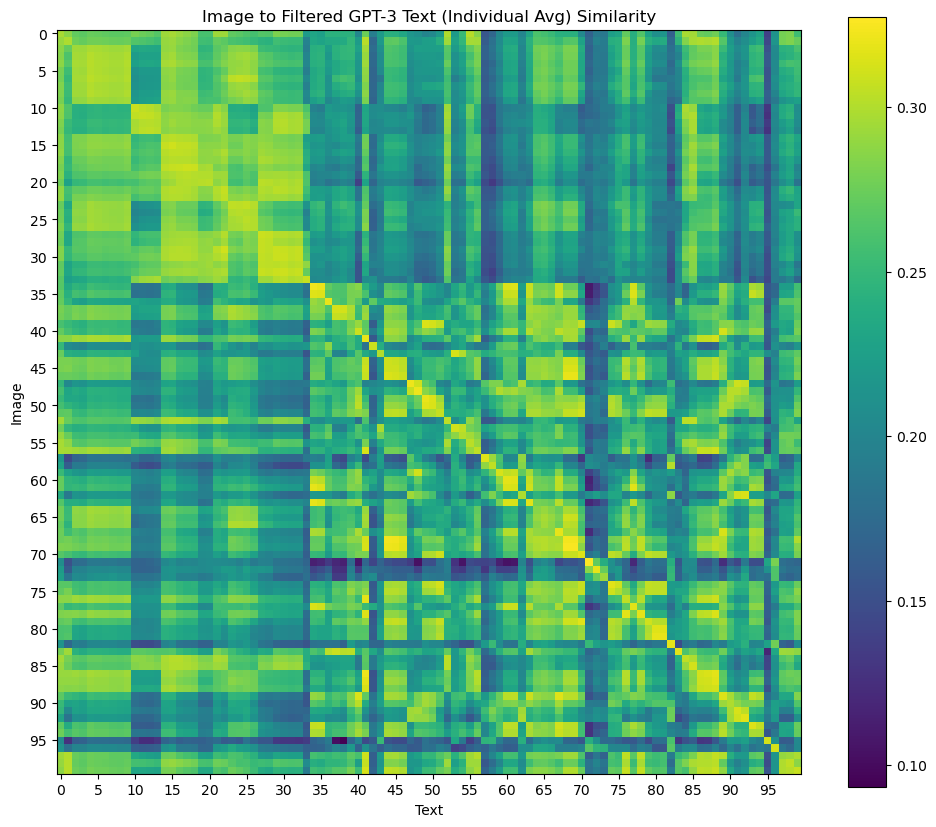

Rank 1: (50)Cessna 560 - (49)Cessna 525, error rate: 0.7352941176470589
Rank 2: (28)A330-300 - (27)A330-200, error rate: 0.6666666666666666
Rank 3: (62)DR-400 - (92)SR-20, error rate: 0.6470588235294118
Rank 4: (43)C-47 - (53)DC-3, error rate: 0.5757575757575758
Rank 5: (39)BAE-125 - (49)Cessna 525, error rate: 0.5454545454545454
Rank 6: (59)DHC-6 - (48)Cessna 208, error rate: 0.5
Rank 7: (86)MD-80 - (41)Boeing 717, error rate: 0.5
Rank 8: (76)Fokker 100 - (41)Boeing 717, error rate: 0.48484848484848486
Rank 9: (7)737-700 - (4)737-400, error rate: 0.48484848484848486
Rank 10: (66)E-195 - (68)ERJ 135, error rate: 0.48484848484848486
Rank 11: (65)E-190 - (68)ERJ 135, error rate: 0.4411764705882353
Rank 12: (80)Gulfstream IV - (81)Gulfstream V, error rate: 0.4411764705882353
Rank 13: (31)A340-500 - (27)A330-200, error rate: 0.42424242424242425
Rank 14: (64)E-170 - (68)ERJ 135, error rate: 0.3939393939393939
Rank 15: (87)MD-87 - (41)Boeing 717, error rate: 0.3939393939393939
Rank 16: (79)G

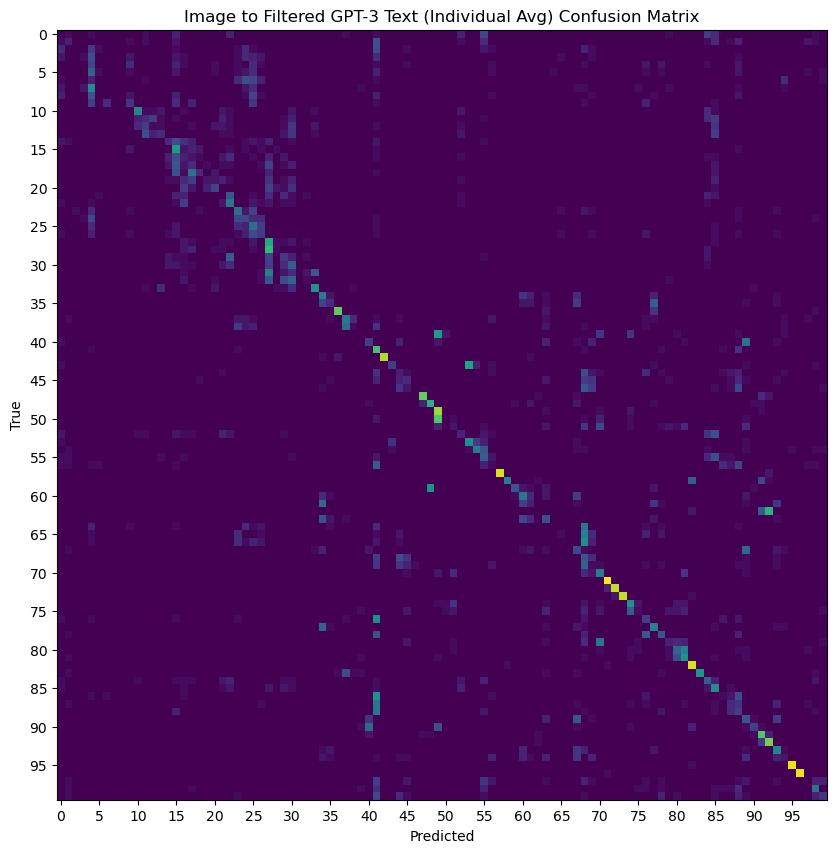

In [33]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [34]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [35]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [36]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (6)737-600 - (7)737-700, similarity: 0.99560546875
Rank 3: (4)737-400 - (6)737-600, similarity: 0.9951171875
Rank 4: (5)737-500 - (6)737-600, similarity: 0.99462890625
Rank 5: (6)737-600 - (8)737-800, similarity: 0.99462890625
Rank 6: (7)737-700 - (8)737-800, similarity: 0.994140625
Rank 7: (5)737-500 - (9)737-900, similarity: 0.994140625
Rank 8: (4)737-400 - (5)737-500, similarity: 0.994140625
Rank 9: (27)A330-200 - (28)A330-300, similarity: 0.99365234375
Rank 10: (3)737-300 - (5)737-500, similarity: 0.99365234375


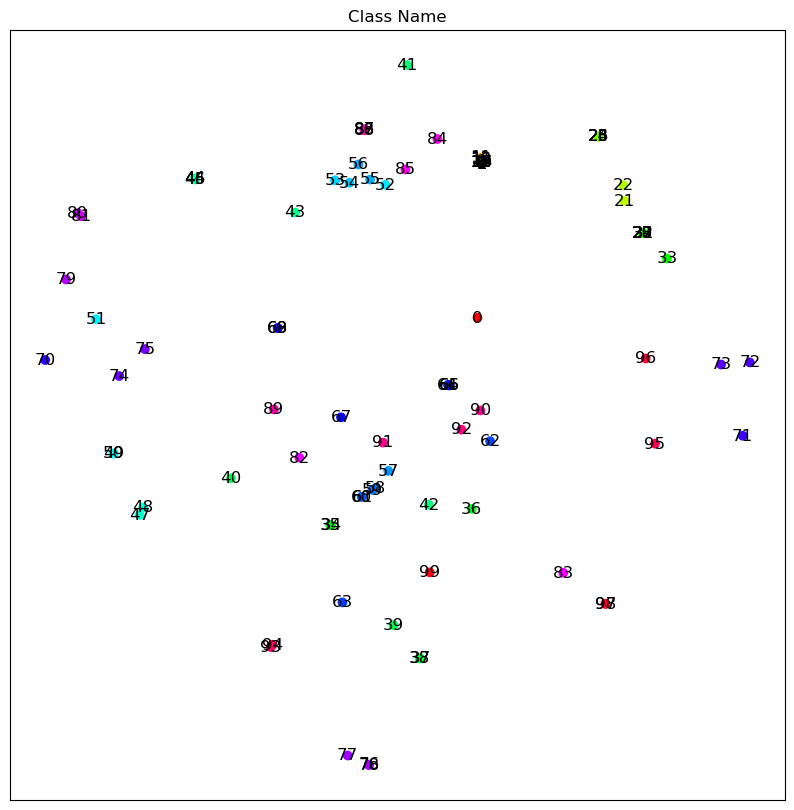

Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 3: (6)737-600 - (7)737-700, similarity: 0.99755859375
Rank 4: (19)777-200 - (20)777-300, similarity: 0.99755859375
Rank 5: (8)737-800 - (9)737-900, similarity: 0.99755859375
Rank 6: (7)737-700 - (9)737-900, similarity: 0.9970703125
Rank 7: (6)737-600 - (8)737-800, similarity: 0.9970703125
Rank 8: (16)767-200 - (17)767-300, similarity: 0.9970703125
Rank 9: (6)737-600 - (9)737-900, similarity: 0.9970703125
Rank 10: (27)A330-200 - (28)A330-300, similarity: 0.9970703125


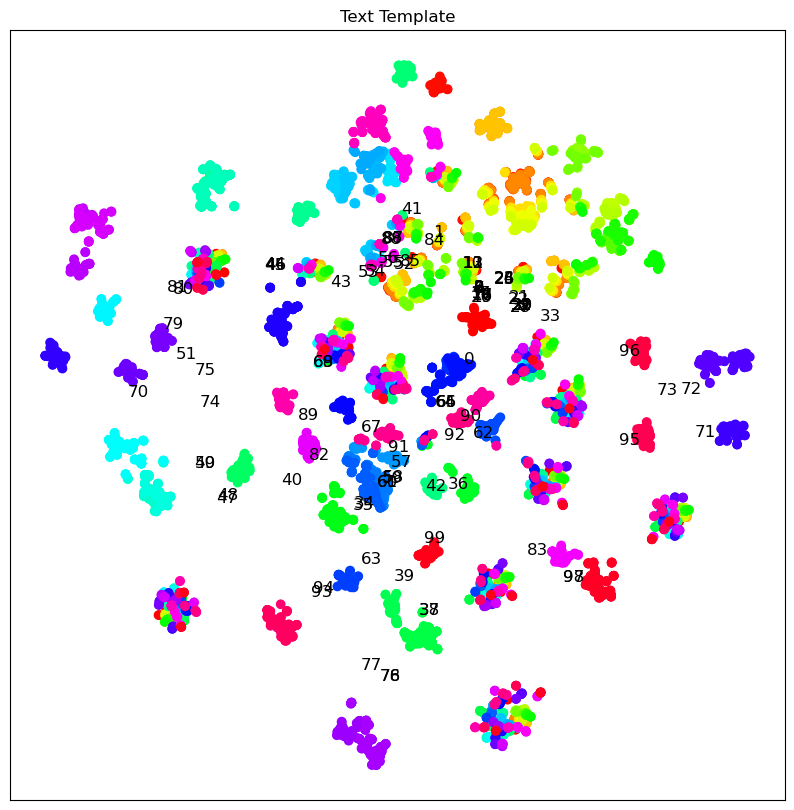

Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.99853515625
Rank 2: (6)737-600 - (9)737-900, similarity: 0.998046875
Rank 3: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, similarity: 0.998046875
Rank 5: (17)767-300 - (18)767-400, similarity: 0.998046875
Rank 6: (30)A340-300 - (32)A340-600, similarity: 0.99755859375
Rank 7: (30)A340-300 - (31)A340-500, similarity: 0.9970703125
Rank 8: (29)A340-200 - (30)A340-300, similarity: 0.9970703125
Rank 9: (5)737-500 - (9)737-900, similarity: 0.9970703125
Rank 10: (6)737-600 - (7)737-700, similarity: 0.99658203125


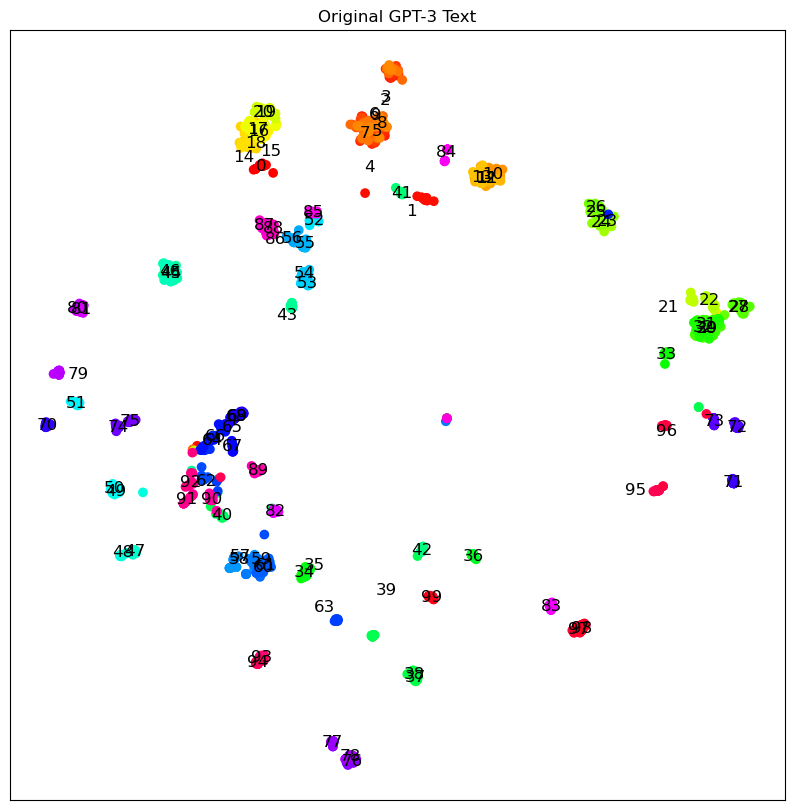

Rank 1: (5)737-500 - (6)737-600, similarity: 0.99853515625
Rank 2: (31)A340-500 - (32)A340-600, similarity: 0.99853515625
Rank 3: (6)737-600 - (9)737-900, similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, similarity: 0.998046875
Rank 5: (5)737-500 - (9)737-900, similarity: 0.99755859375
Rank 6: (17)767-300 - (18)767-400, similarity: 0.99755859375
Rank 7: (30)A340-300 - (32)A340-600, similarity: 0.99755859375
Rank 8: (4)737-400 - (5)737-500, similarity: 0.99755859375
Rank 9: (6)737-600 - (8)737-800, similarity: 0.99755859375
Rank 10: (7)737-700 - (9)737-900, similarity: 0.99755859375


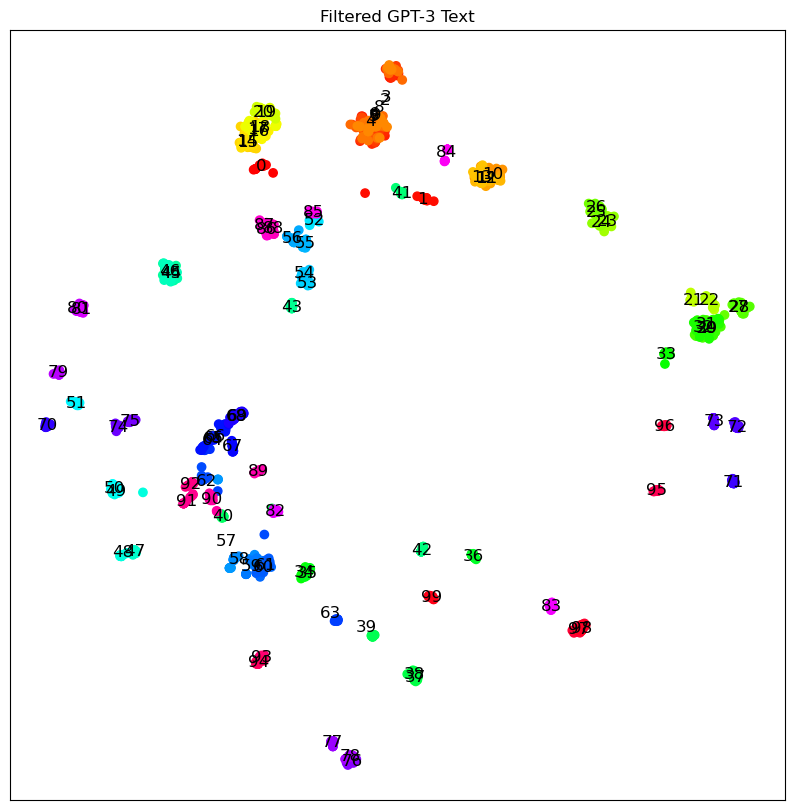

In [37]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')